In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import IntegerLookup, Input, Dense, BatchNormalization, Dropout, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
filename = 'train_low_mem.parquet'

In [4]:
df = pd.read_parquet(filename)

In [5]:
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [6]:
df.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


All 300 features have a mean near 0 and a std near 1 -> no scaling needed

# Split the data

row_id and time_id will not be needed; investment_id will be fed separatedly into the NN

In [7]:
def train_val_test_split(data):
    y = data['target']
    X = data.drop(['row_id', 'time_id', 'target'], axis=1)
    X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size=0.2, random_state=42, shuffle=True)
    investment_id_train = X_train.pop('investment_id')
    investment_id_valid = X_valid.pop('investment_id')
    investment_id_test = X_test.pop('investment_id')

    return X_train, X_valid, X_test, y_train, y_valid, y_test, investment_id_train, investment_id_valid, investment_id_test

In [8]:
X_train, X_valid, X_test, y_train, y_valid, y_test, investment_id_train, investment_id_valid, investment_id_test = train_val_test_split(data=df)

# Visualize/ unterstand the data; search for correlations

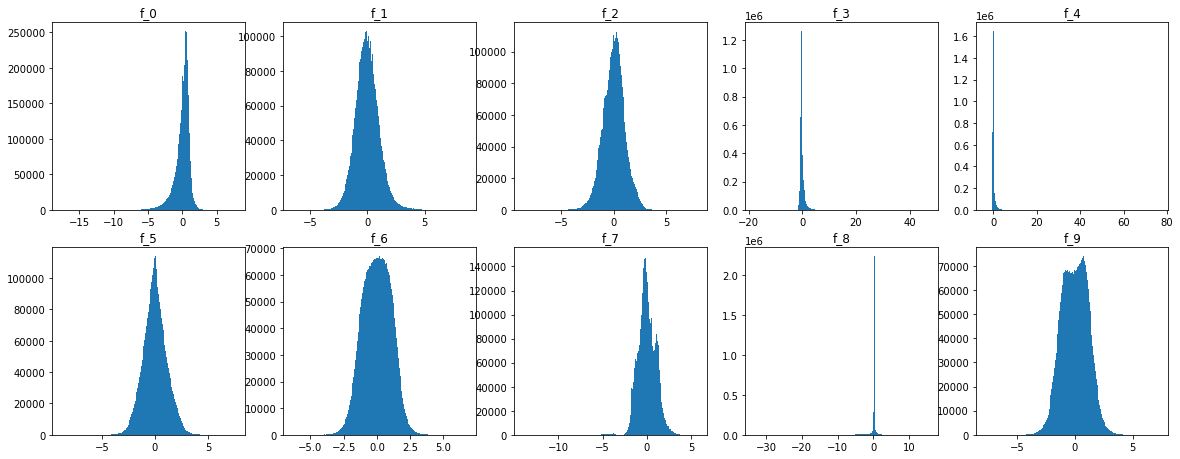

In [9]:
#plot the first 10 features as an example
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i+1)
    feature = f'f_{i}'
    plt.hist(df[feature], bins=200)
    plt.title(f'f_{i}')

Some features look really compressed, maybe because of an outlier (check f_4)

In [10]:
values_f_4_35std = 0  # number of values larger mean + 35std or smaller mean - 35std
values_f_4_50std = 0
values_f_4_70std = 0
values_f_4_100std = 0

f_4_std = df['f_4'].std()
f_4_mean = df['f_4'].mean()

for row in df['f_4']:
    if row > f_4_mean + 35 * f_4_std or row < f_4_mean - 35 * f_4_std:
        values_f_4_35std += 1
    if row > f_4_mean + 50 * f_4_std or row < f_4_mean - 50 * f_4_std:
        values_f_4_50std += 1
    if row > f_4_mean + 70 * f_4_std or row < f_4_mean - 70 * f_4_std:
        values_f_4_70std += 1
    if row > f_4_mean + 100 * f_4_std or row < f_4_mean - 100 * f_4_std:
        values_f_4_100std += 1

print('Values 35 Std: ', values_f_4_35std)
print('Values 50 Std: ', values_f_4_50std)
print('Values 70 Std: ', values_f_4_70std)
print('Values 100 Std: ', values_f_4_100std)

Values 35 Std:  370
Values 50 Std:  139
Values 70 Std:  6
Values 100 Std:  0


Looks like outliers above 70; other features might have outliers lower

## Correlation between f_0 - f_300 and target

In [11]:
X_train.corrwith(y_train).sort_values(ascending=False)

f_119    0.048881
f_270    0.045562
f_93     0.039986
f_76     0.039131
f_225    0.038725
           ...   
f_197   -0.044864
f_280   -0.046465
f_265   -0.047344
f_250   -0.055037
f_231   -0.061458
Length: 300, dtype: float64

Only very low correlation

# Remove outliers

In [12]:
def get_outliers(df):  # return outlier indexes in a list
    feature_columns = df.columns
    outlier_list = []
    outlier_column = []

    for column in feature_columns:
        #filter for outliers > 70 std.
        filter_std_70 = ((df[column] > (df[column].mean() + df[column].std() * 70)) |
                         (df[column] < (df[column].mean() - df[column].std() * 70)))
        #filter for outliers > 35 std.
        filter_std_35 = ((df[column] > (df[column].mean() + df[column].std() * 35)) |
                         (df[column] < (df[column].mean() - df[column].std() * 35)))

        filtered_df_70 = df[filter_std_70] # df with boolean values of applied filter
        filtered_df_35 = df[filter_std_35]

        if len(filtered_df_70) > 0: # one value of the column is greater/smaller then the mean +/- 70*std
            outliers = filtered_df_70.index.to_list() # collect indexes of the rows 
            outlier_list.extend(outliers)
            outlier_column.append(column)
        elif len(filtered_df_35) > 0 and len(filtered_df_35) < 6: # <6: dont remove too many values (only outliers)
            outliers = filtered_df_35.index.to_list()
            outlier_list.extend(outliers)
            outlier_column.append(column)

    outlier_list = list(set(outlier_list)) # make a set -> remove dublicates -> make list again (without dublicates)
    print('Number of Outliers: ', len(outlier_list), '; Number of Columns with Outliers: ', len(outlier_column))
    
    return outlier_list

In [13]:
outlier_list_X_train = get_outliers(X_train)

Number of Outliers:  108 ; Number of Columns with Outliers:  38


In [14]:
print(f'X_length: {len(X_train)}; y_length: {len(y_train)}') 

X_length: 2010502; y_length: 2010502


In [15]:
X_train.drop(outlier_list_X_train, axis=0, inplace=True) # remove outliers
investment_id_train.drop(outlier_list_X_train, axis=0, inplace=True)
y_train.drop(outlier_list_X_train, axis=0, inplace=True)

In [16]:
print(f'X_length: {len(X_train)}; y_length: {len(y_train)}')

X_length: 2010394; y_length: 2010394


In [17]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [18]:
investment_id = investment_id_train

In [19]:
investment_id.value_counts()

952     825
1111    815
994     813
2173    808
395     807
       ... 
2558      5
85        4
905       3
3662      3
1415      2
Name: investment_id, Length: 3578, dtype: int64

# Build a model and tune the hyperparameter

In [20]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

In [21]:
#build the model using keras-tuner

def build_model_1(hp):
    investment_id_inputs = Input((1,), dtype=tf.uint16)
    features_inputs = Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(input_dim=investment_id_size, output_dim=hp.Choice('Embedding_Output_Dim', [4, 8, 16, 32, 64, 128, 256]), input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_1_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_2_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_2_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_3_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_3_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_4_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_4_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_5_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_5_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_6_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_6_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    
    drop_rate = hp.Float('Dropout_Rate', 0.1, 0.5, 0.1)
    
    feature_x = Dense(units=hp.Choice('2_Branch_1_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(features_inputs)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    if hp.Boolean('2_Brach_2_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_2_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_3_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_3_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_4_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_4_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_5_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_5_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_6_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_6_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    
    drop_rate_2 = hp.Float('Dropout_Rate_2', 0.1, 0.5, 0.1)
    
    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(units=hp.Choice('3_Branch_1_Dense_Units', [64, 128, 256, 512]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_2_Dense'):
        x = Dense(hp.Choice('3_Branch_2_Dense_Units', [64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_3_Dense'):
        x = Dense(hp.Choice('3_Branch_3_Dense_Units', [32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_4_Dense'):
        x = Dense(hp.Choice('3_Branch_4_Dense_Units', [16, 32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_5_Dense'):
        x = Dense(hp.Choice('3_Branch_5_Dense_Units', [8, 16, 32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    
    output = Dense(1)(x)
    
    rmse = RootMeanSquaredError(name='rmse')
    model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    LEARNING_RATE = hp.Float("Learning_Rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=[rmse])
    
    return model

In [22]:
tuner_1 = kt.RandomSearch(
    hypermodel=build_model_1,
    objective='val_loss',
    max_trials=120,
    directory='Logs_Branches_1')

INFO:tensorflow:Reloading Oracle from existing project Logs_Branches_1/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from Logs_Branches_1/untitled_project/tuner0.json


In [40]:
tuner_1.search((investment_id_train, X_train), y_train, epochs=20, batch_size=1024, callbacks=[EarlyStopping(patience=3)],
               validation_data=((investment_id_valid, X_valid), y_valid))

Trial 120 Complete [00h 02m 11s]
val_loss: 0.8303437829017639

Best val_loss So Far: 0.8164860010147095
Total elapsed time: 03h 40m 28s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner_1.results_summary(5)

Results summary
Results in Logs_Branches_1/untitled_project
Showing 5 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Embedding_Output_Dim: 8
1_Branch_1_Dense_Units: 128
1_Branch_2_Dense: False
1_Branch_3_Dense: False
1_Branch_4_Dense: True
1_Branch_5_Dense: True
1_Branch_6_Dense: True
Dropout_Rate: 0.30000000000000004
2_Branch_1_Dense_Units: 512
2_Brach_2_Dense: True
2_Brach_3_Dense: False
2_Brach_4_Dense: True
2_Brach_5_Dense: True
2_Brach_6_Dense: True
Dropout_Rate_2: 0.30000000000000004
3_Branch_1_Dense_Units: 64
3_Branch_2_Dense: True
3_Branch_3_Dense: True
3_Branch_4_Dense: False
3_Branch_5_Dense: True
Learning_Rate: 0.005180937737654028
1_Branch_2_Dense_Units: 8
1_Branch_5_Dense_Units: 4
1_Branch_6_Dense_Units: 16
2_Branch_2_Dense_Units: 512
2_Branch_3_Dense_Units: 64
2_Branch_4_Dense_Units: 32
2_Branch_6_Dense_Units: 512
3_Branch_4_Dense_Units: 64
2_Branch_5_Dense_Units: 32
3_Branch_2_Dense_Units: 64
3_Branch_3_Dense_Units: 32
1_Branch_3_D

In [24]:
def build_model_2(hp):
    investment_id_inputs = Input((1,), dtype=tf.uint16)
    features_inputs = Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(input_dim=investment_id_size, output_dim=hp.Choice('Embedding_Output_Dim', [4, 8, 16, 32, 64, 128, 256]), input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_1_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_2_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_3_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_4_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_4_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_5_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_5_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_6_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_6_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    
    drop_rate = hp.Float('Dropout_Rate', 0.2, 0.5, 0.1)
    
    feature_x = Dense(units=hp.Choice('2_Branch_1_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(features_inputs)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    feature_x = Dense(units=hp.Choice('2_Branch_2_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    if hp.Boolean('2_Brach_3_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_3_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_4_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_4_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_5_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_5_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    if hp.Boolean('2_Brach_6_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_6_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    
    drop_rate_2 = hp.Float('Dropout_Rate_2', 0.2, 0.5, 0.1)
    
    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(units=hp.Choice('3_Branch_1_Dense_Units', [64, 128, 256, 512]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    
    x = Dense(hp.Choice('3_Branch_2_Dense_Units', [64, 128, 256]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    
    if hp.Boolean('3_Branch_3_Dense'):
        x = Dense(hp.Choice('3_Branch_3_Dense_Units', [32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_4_Dense'):
        x = Dense(hp.Choice('3_Branch_4_Dense_Units', [16, 32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    if hp.Boolean('3_Branch_5_Dense'):
        x = Dense(hp.Choice('3_Branch_5_Dense_Units', [8, 16, 32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    
    output = Dense(1)(x)
    
    rmse = RootMeanSquaredError(name='rmse')
    model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    LEARNING_RATE = hp.Float("Learning_Rate", 0.001, 0.005, 0.001)
    model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=[rmse])
    
    return model

In [25]:
tuner_2 = kt.RandomSearch(
    hypermodel=build_model_2,
    objective='val_loss',
    max_trials=50,
    directory='Logs_Branches_2')

INFO:tensorflow:Reloading Oracle from existing project Logs_Branches_2/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from Logs_Branches_2/untitled_project/tuner0.json


In [24]:
tuner_2.search((investment_id_train, X_train), y_train, epochs=20, batch_size=1024, callbacks=[EarlyStopping(patience=3)],
               validation_data=((investment_id_valid, X_valid), y_valid))

Trial 50 Complete [00h 02m 03s]
val_loss: 0.8274447321891785

Best val_loss So Far: 0.8176179528236389
Total elapsed time: 01h 32m 27s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner_2.results_summary(5)

Results summary
Results in Logs_Branches_2/untitled_project
Showing 5 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Embedding_Output_Dim: 4
1_Branch_1_Dense_Units: 512
1_Branch_2_Dense_Units: 16
1_Branch_3_Dense_Units: 512
1_Branch_4_Dense: False
1_Branch_5_Dense: False
1_Branch_6_Dense: True
Dropout_Rate: 0.2
2_Branch_1_Dense_Units: 512
2_Branch_2_Dense_Units: 64
2_Brach_3_Dense: True
2_Brach_4_Dense: False
2_Brach_5_Dense: False
2_Brach_6_Dense: False
Dropout_Rate_2: 0.30000000000000004
3_Branch_1_Dense_Units: 128
3_Branch_2_Dense_Units: 128
3_Branch_3_Dense: False
3_Branch_4_Dense: False
3_Branch_5_Dense: True
Learning_Rate: 0.003
1_Branch_4_Dense_Units: 512
2_Branch_3_Dense_Units: 64
2_Branch_4_Dense_Units: 128
2_Branch_5_Dense_Units: 128
3_Branch_3_Dense_Units: 256
1_Branch_6_Dense_Units: 32
2_Branch_6_Dense_Units: 256
3_Branch_4_Dense_Units: 16
3_Branch_5_Dense_Units: 8
Score: 0.8176179528236389
Trial summary
Hyperparameters:
Embedding_Out

In [27]:
def build_model_3(hp):
    investment_id_inputs = Input((1,), dtype=tf.uint16)
    features_inputs = Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(input_dim=investment_id_size, output_dim=4, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_1_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_2_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_3_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
    if hp.Boolean('1_Branch_4_Dense'):
        investment_id_x = Dense(units=hp.Choice('1_Branch_4_Dense_Units', [4, 8, 16, 32, 64, 128, 256, 512]), activation='relu')(investment_id_x)
        
    drop_rate = hp.Float('Dropout_Rate', 0.2, 0.5, 0.1)
    
    feature_x = Dense(units=512)(features_inputs)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    feature_x = Dense(units=hp.Choice('2_Branch_2_Dense_Units', [64, 128, 256]))(feature_x)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    feature_x = Dense(units=hp.Choice('2_Branch_3_Dense_Units', [32, 64, 128]))(feature_x)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=drop_rate)(feature_x)
    
    if hp.Boolean('2_Brach_4_Dense'):
        feature_x = Dense(units=hp.Choice('2_Branch_4_Dense_Units', [16, 32, 64, 128]))(feature_x)
        feature_x = BatchNormalization()(feature_x)
        feature_x = Activation('relu')(feature_x)
        feature_x = Dropout(rate=drop_rate)(feature_x)
    
    drop_rate_2 = hp.Float('Dropout_Rate_2', 0.2, 0.5, 0.1)
    
    x = Concatenate(axis=1)([investment_id_x, feature_x])
    
    x = Dense(units=hp.Choice('3_Branch_1_Dense_Units', [64, 128, 256, 512]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    
    x = Dense(hp.Choice('3_Branch_2_Dense_Units', [64, 128, 256]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    
    x = Dense(hp.Choice('3_Branch_3_Dense_Units', [16, 32, 64, 128, 256]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=drop_rate_2)(x)
    
    if hp.Boolean('3_Branch_4_Dense'):
        x = Dense(hp.Choice('3_Branch_4_Dense_Units', [8, 16, 32, 64]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=drop_rate_2)(x)
    
    output = Dense(1)(x)
    
    rmse = RootMeanSquaredError(name='rmse')
    model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    LEARNING_RATE = hp.Float("Learning_Rate", 0.002, 0.003, 0.0005)
    model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=[rmse])
    
    return model

In [28]:
tuner_3 = kt.RandomSearch(
    hypermodel=build_model_3,
    objective='val_loss',
    max_trials=50,
    directory='Logs_Branches_3')

INFO:tensorflow:Reloading Oracle from existing project Logs_Branches_3/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from Logs_Branches_3/untitled_project/tuner0.json


In [ ]:
tuner_3.search((investment_id_train, X_train), y_train, epochs=20, batch_size=1024, callbacks=[EarlyStopping(patience=3)],
               validation_data=((investment_id_valid, X_valid), y_valid))

In [29]:
tuner_3.results_summary(3)

Results summary
Results in Logs_Branches_3/untitled_project
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
1_Branch_1_Dense_Units: 8
1_Branch_2_Dense_Units: 512
1_Branch_3_Dense_Units: 64
1_Branch_4_Dense: True
Dropout_Rate: 0.4000000000000001
2_Branch_2_Dense_Units: 256
2_Branch_3_Dense_Units: 128
2_Brach_4_Dense: False
Dropout_Rate_2: 0.4000000000000001
3_Branch_1_Dense_Units: 128
3_Branch_2_Dense_Units: 128
3_Branch_3_Dense_Units: 64
3_Branch_4_Dense: False
Learning_Rate: 0.0025
3_Branch_4_Dense_Units: 32
2_Branch_4_Dense_Units: 64
1_Branch_4_Dense_Units: 4
Score: 0.8164013028144836
Trial summary
Hyperparameters:
1_Branch_1_Dense_Units: 128
1_Branch_2_Dense_Units: 64
1_Branch_3_Dense_Units: 8
1_Branch_4_Dense: False
Dropout_Rate: 0.30000000000000004
2_Branch_2_Dense_Units: 128
2_Branch_3_Dense_Units: 32
2_Brach_4_Dense: False
Dropout_Rate_2: 0.4000000000000001
3_Branch_1_Dense_Units: 128
3_Branch_2_Dense_Units: 256
3_Branch_3_Dense_U

In [30]:
def build_model_4(hp):
    investment_id_inputs = Input((1,), dtype=tf.uint16)
    features_inputs = Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(input_dim=investment_id_size, output_dim=4, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_1_Dense_Units', [64, 128, 256, 512]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_2_Dense_Units', [32, 64, 128]), activation='relu')(investment_id_x)
    investment_id_x = Dense(units=hp.Choice('1_Branch_3_Dense_Units', [4, 8, 16]), activation='relu')(investment_id_x)
    
    feature_x = Dense(units=512)(features_inputs)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=0.4)(feature_x)
    
    feature_x = Dense(units=256)(feature_x)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=0.4)(feature_x)
    
    feature_x = Dense(units=128)(feature_x)
    feature_x = BatchNormalization()(feature_x)
    feature_x = Activation('relu')(feature_x)
    feature_x = Dropout(rate=0.4)(feature_x)
    
    x = Concatenate(axis=1)([investment_id_x, feature_x])
    
    x = Dense(units=128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.4)(x)
    
    x = Dense(units=128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.4)(x)
    
    x = Dense(units=128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.4)(x)
    
    output = Dense(1)(x)
    
    rmse = RootMeanSquaredError(name='rmse')
    model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.002), metrics=[rmse])
    
    return model

In [31]:
tuner_4 = kt.RandomSearch(
    hypermodel=build_model_4,
    objective='val_loss',
    max_trials=20,
    directory='Logs_Branches_4')

INFO:tensorflow:Reloading Oracle from existing project Logs_Branches_4/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from Logs_Branches_4/untitled_project/tuner0.json


In [ ]:
tuner_4.search((investment_id_train, X_train), y_train, epochs=40, batch_size=1024, callbacks=[EarlyStopping(patience=3)],
               validation_data=((investment_id_valid, X_valid), y_valid))

In [32]:
best_params = tuner_4.get_best_hyperparameters()[0]

In [33]:
best_model = build_model_4(best_params)

In [34]:
es = EarlyStopping(patience=5)
tb = TensorBoard()
cb = [es, tb]

In [35]:
best_model.compile(loss='mse', optimizer=Adam(learning_rate=0.002), metrics=[RootMeanSquaredError(name='rmse')])

In [36]:
best_model.fit((investment_id_train, X_train), y_train, epochs=50, batch_size=1024, callbacks=cb,
               validation_data=((investment_id_valid, X_valid), y_valid))

Epoch 1/50
1964/1964 [==============================] - 10s 5ms/step - loss: 0.8546 - rmse: 0.9245 - val_loss: 0.8290 - val_rmse: 0.9105
Epoch 2/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8312 - rmse: 0.9117 - val_loss: 0.8278 - val_rmse: 0.9098
Epoch 3/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8289 - rmse: 0.9104 - val_loss: 0.8258 - val_rmse: 0.9088
Epoch 4/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8272 - rmse: 0.9095 - val_loss: 0.8247 - val_rmse: 0.9081
Epoch 5/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8255 - rmse: 0.9086 - val_loss: 0.8252 - val_rmse: 0.9084
Epoch 6/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8241 - rmse: 0.9078 - val_loss: 0.8223 - val_rmse: 0.9068
Epoch 7/50
1964/1964 [==============================] - 8s 4ms/step - loss: 0.8225 - rmse: 0.9069 - val_loss: 0.8224 - val_rmse: 0.9069
Epoch 8/50
1964/1964 [=========================

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs

Best validation-loss after epoch 17

In [38]:
#evaluate with test-set
best_model.evaluate((investment_id_test, X_test), y_test)

19634/19634 [==============================] - 23s 1ms/step - loss: 0.8216 - rmse: 0.9064


[0.8215869069099426, 0.9064143300056458]

# Use full data with 20 epochs and save the final model

In [39]:
y = df['target']
X = df.drop(['row_id', 'time_id', 'target'], axis=1)
investment_id = X.pop('investment_id')

In [40]:
print(f'X_length: {len(X)}; y_length: {len(y)}')

X_length: 3141410; y_length: 3141410


In [41]:
outlier_list_df = get_outliers(X)

Number of Outliers:  174 ; Number of Columns with Outliers:  48


In [42]:
X.drop(outlier_list_df, axis=0, inplace=True) # remove outliers
investment_id.drop(outlier_list_df, axis=0, inplace=True)
y.drop(outlier_list_df, axis=0, inplace=True)

In [43]:
print(f'X_length: {len(X)}; y_length: {len(y)}')

X_length: 3141236; y_length: 3141236


In [44]:
X = np.array(X)

In [45]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

In [46]:
investment_id_inputs = Input((1,), dtype=tf.uint16)
features_inputs = Input((300, ), dtype=tf.float16)
    
investment_id_x = investment_id_lookup_layer(investment_id_inputs)
investment_id_x = Embedding(input_dim=investment_id_size, output_dim=4, input_length=1)(investment_id_x)
investment_id_x = Reshape((-1, ))(investment_id_x)
investment_id_x = Dense(units=256, activation='relu')(investment_id_x)
investment_id_x = Dense(units=128, activation='relu')(investment_id_x)
investment_id_x = Dense(units=4, activation='relu')(investment_id_x)
    
feature_x = Dense(units=512)(features_inputs)
feature_x = BatchNormalization()(feature_x)
feature_x = Activation('relu')(feature_x)
feature_x = Dropout(rate=0.4)(feature_x)
    
feature_x = Dense(units=256)(feature_x)
feature_x = BatchNormalization()(feature_x)
feature_x = Activation('relu')(feature_x)
feature_x = Dropout(rate=0.4)(feature_x)
    
feature_x = Dense(units=128)(feature_x)
feature_x = BatchNormalization()(feature_x)
feature_x = Activation('relu')(feature_x)
feature_x = Dropout(rate=0.4)(feature_x)
    
x = Concatenate(axis=1)([investment_id_x, feature_x])
   
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.4)(x)
    
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.4)(x)
    
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.4)(x)
    
output = Dense(1)(x)
  
rmse = RootMeanSquaredError(name='rmse')
model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.002), metrics=[rmse])

In [47]:
model.fit((investment_id, X), y, epochs=20, batch_size=1024)

Epoch 1/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8511 - rmse: 0.9226
Epoch 2/20
3068/3068 [==============================] - 11s 4ms/step - loss: 0.8301 - rmse: 0.9111
Epoch 3/20
3068/3068 [==============================] - 11s 4ms/step - loss: 0.8279 - rmse: 0.9099
Epoch 4/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8259 - rmse: 0.9088
Epoch 5/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8240 - rmse: 0.9077
Epoch 6/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8221 - rmse: 0.9067
Epoch 7/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8204 - rmse: 0.9058
Epoch 8/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8188 - rmse: 0.9049
Epoch 9/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8174 - rmse: 0.9041
Epoch 10/20
3068/3068 [==============================] - 12s 4ms/step - loss: 0.8158 - rmse: 0.9032
Epoch 11/

In [48]:
model.save_weights('model_weights')